In [1]:
import os
import sys
import torch
from fiftyone import ViewField as F
import fiftyone as fo
from cleanlab.segmentation.rank import get_label_quality_scores, issues_from_scores 
from cleanlab.segmentation.summary import display_issues
parent_directory = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(parent_directory,"seametrics"))
from softmin_score.utils import compute_and_upload_softmin, compute_and_upload_softmin

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_NAME = "TRAIN_PANOPTIC_DATASET"
MODEL_PATH =  "SEA-AI/maskformer-27k-100epochs"
MODEL_NAME = "maskformer-27k-100epochs"
SOFTMIN_MASK_FIELD = "softmin_errors"
SOFTMIN_SCORE_FIELD = "softmin_score"
TARGET_SIZE = (640, 512)

### Loading the dataset

In [3]:
dataset = fo.load_dataset(DATASET_NAME) 

In [4]:
# dataset_view = dataset.match(F("metadata.height")==640).take(10)
dataset_view = dataset.match(F("filepath").ends_with(["17995902_r.jpg", "15616105_r.jpg", "23562072_r.jpg"])) #change this to be smaller than the entire dataset if you want to do a quick test

### Compute the average softmin score over a dataset

In [5]:
avg_softmin_score, pred_probs_all_np, ground_truth_labels_all_np = compute_and_upload_softmin(dataset_view, MODEL_PATH, TARGET_SIZE, SOFTMIN_MASK_FIELD, SOFTMIN_SCORE_FIELD, device=DEVICE)


Backbone maskformer-swin is not a supported model and may not be compatible with MaskFormer. Supported model types: resnet,swin
  0%|          | 0/3 [00:00<?, ?it/s]

images processed using softmin:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:02<00:05,  2.70s/it]

images processed using softmin:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:02<00:01,  1.20s/it]

images processed using softmin:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


In [6]:
avg_softmin_score

0.28496666666666665

### Visualize the outputs of softmin

images processed using softmin:   0%|          | 0/3 [00:00<?, ?it/s]

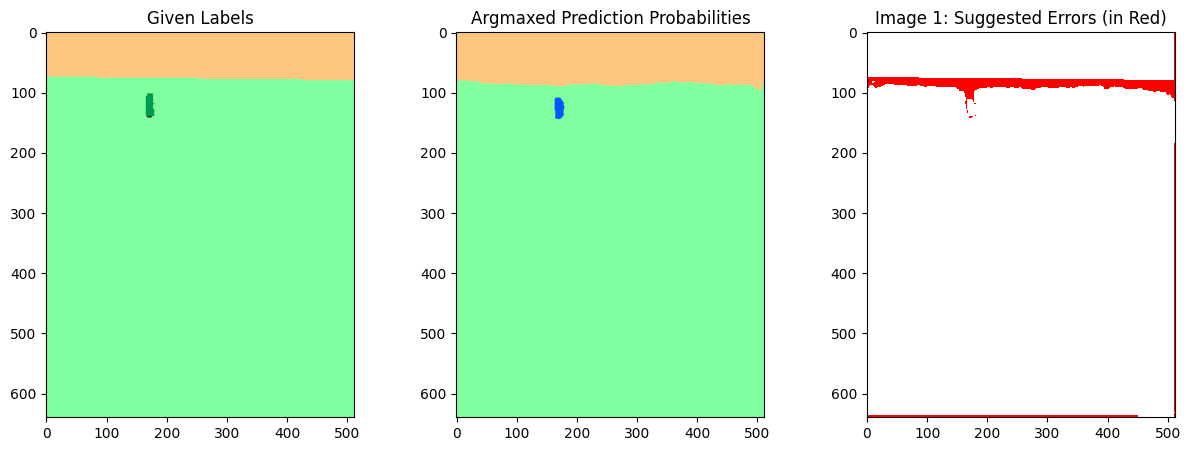

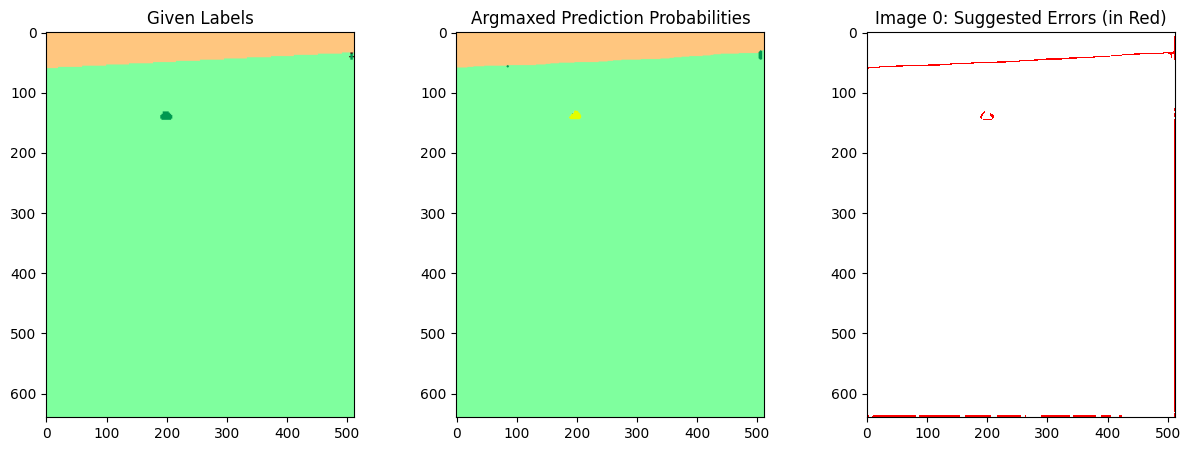

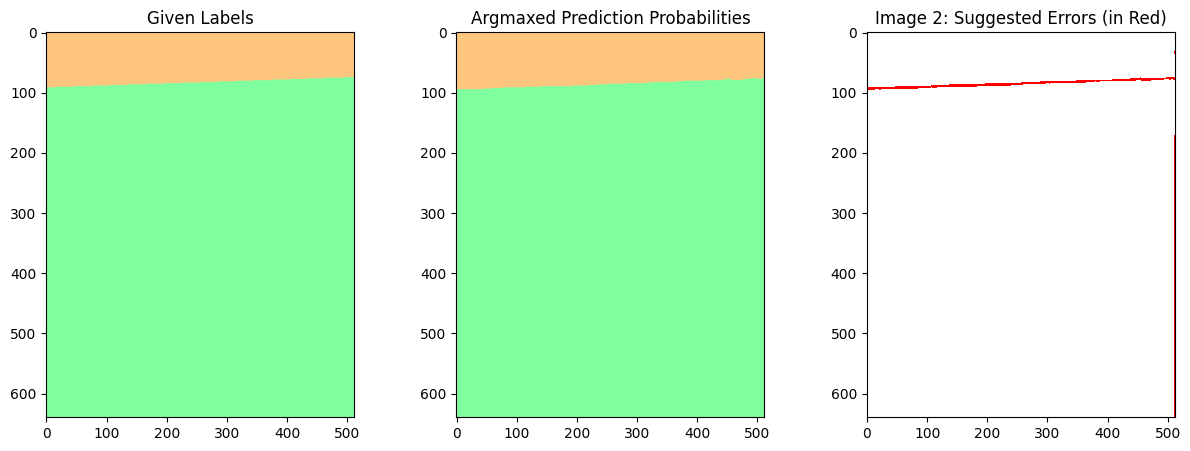

In [7]:
# issues = find_label_issues(ground_truth_labels_all_np, pred_probs_all_np, downsample = 4, n_jobs=None, batch_size=1)
image_scores, pixel_scores = get_label_quality_scores(labels=ground_truth_labels_all_np, pred_probs=pred_probs_all_np)
issues_from_score = issues_from_scores(image_scores, pixel_scores, threshold=0.5)

display_issues(issues_from_score, labels=ground_truth_labels_all_np, pred_probs=pred_probs_all_np, top=5)